In [91]:
import pandas as pd
import numpy as np
import networkx as nx
import itertools
import random

In [23]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [24]:
from typing import Union, List, Tuple

In [328]:
from sympy import symbols, sympify

# Index

This second notebook covers the following intermediate Graph Theory topics:

1. [Multigraphs](#Multigraphs)\
   1.1 [An applications of Multigraph in Social Network analysis](#An-applications-of-Multigraph-in-Social-Network-analysis)
2. [Coloring Theory](#Coloring-Theory)\
   2.1 [The Brooks Theorems](#The-Brooks-Theorems)\
   2.2 [The chromatic polynomial](#The-chromatic-polynomial)
3. [Introduction to Algebraic Graph Theory: the Adjacency Matrix](#Introduction-to-Algebraic-Graph-Theory:-the-Adjacency-Matrix)\
   3.1 [The spectrum of a graph](#The-spectrum-of-a-graph)

In [25]:
def plot_multigraph(G: nx.MultiGraph(), type_curvature, figsize=(4, 4), **node_args):
    '''
    Function to visualize a NetWorkx Graph

    Args:
        G (nx.Graph): a Networkx Graph
        kwargs (optional keyword arguments): additional arguments to customize the visualization

    Returns:
        The graph visualization
    '''
    fig, ax = plt.subplots(figsize=figsize)
    
    ax.set_title("Graph Visual", fontsize=12)

    pos = nx.spring_layout(G)
    
    # Draw nodes and edges
    nx.draw_networkx_nodes(G, pos, **node_args)
    nx.draw_networkx_labels(G, pos, font_size=14, font_weight="bold")
    
    # Draw distinct edges with different curvature
    for (u, v, data) in G.edges(data=True):
        edge_type = data["type"]
        nx.draw_networkx_edges(
            G, pos, edgelist=[(u, v)],
            width=2, alpha=0.7, 
            connectionstyle=f"arc3,rad={type_curvature[edge_type]}"
        )

    # Add edge labels
    edge_labels = {(u, v): d["type"] for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12)
    

    plt.show()

# Intermediate concepts in Graph Theory: from *Multigraphs* to *Bipartite Graphs*

In the first notebook, we covered the basics of Graph Theory, introducing concepts such as simple graphs and exploring fundamental theorems regarding their structure and topology. Additionally, we demonstrated how to work with simple graphs in Python using the `networkx` package. In this notebook, we will delve deeper into the subject by discussing more advanced topics, including *multigraphs* and the so-called coloring theory. Furthermore, we will explore different graph representations, such as *adjacency matrices*, which enable the application of important results from linear algebra to graphs. Finally, we will examine *bipartite graphs*, a special class of graphs that naturally arise in various fields, from social networks to solid-state physics.

## Multigraphs

**Definition**: Let $V$ be a set. Then we define $P_{1,2}(V)$ the set of all 1-element or 2-element subsets of $V$, i.e.:
$$
P_{1,2}(V) = \{ S \subseteq V | |S| = {1, 2} \}  = \{ \{ u, v\} | u, v \in V \} \ \text{not necessarily distinct}
$$
For example, $P_{1, 2}(1, 2, 3) = \{ \{1\}, \{2\}, \{3\}, \{1, 2\}, \{2, 3\}, \{1, 3\}\}$. 

**Definition**: A **multigraph** is defined as $G=(E, V, \varphi)$ a set of three elements: $E$ is the **edge set**, $V$ is the **vertices set** and $\varphi$ is a map defined as $\varphi: E \rightarrow P_{1,2}(V)$.

Roughly speaking, we may say that a *multigraph* is a graph where two vertices can be connected by more than one edge (distinct elements of $P_{1, 2}(V)$ of dimension 2) and one edge can connect a node with itself (elements of dimension 1 in $P_{1,2}(V)$. Let us show how to define a multigraph in `networkx`:

In [26]:
# using the MultiGraph class
G = nx.MultiGraph()

In [27]:
nodes = [1, 2, 3, 4]
edges = [(1, 2, "A"), (1, 1, "A"), (2, 3, "A"), (2, 3, "B"), (3, 4, "A")]

In [28]:
G.add_nodes_from(nodes)
G.add_edges_from((u, v, {"type": label}) for u, v, label in edges)

[0, 0, 0, 1, 0]

Notice that we have introduced an additional parameter when defining edges, namely `type`, which in the above example can be "A" or "B":

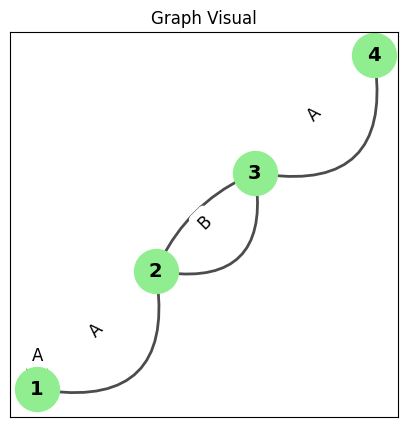

In [29]:
plot_multigraph(
    G, 
    type_curvature={"A": .7, "B": -0.2},
    figsize=(5,5),
    node_color="lightgreen",
    node_size=1000
)

All the definitions given for simple graphs still hold for multigraph. In particular, the **degree** $\deg(v)$ of a vertex $v \in V$ in a multigraph is the number of edges that contain $v$, where loops are counted twice:
$$
\deg v := | \{e \in E | v \in \varphi(e)\}| + | \{ e \in E | \varphi(E) = \{ v\} \}|
$$
Notice that, unlike for simple graphs, in multigraphs the degree of a node is not the number of **neigbors** of $v$, unless $v$ is not contained in any loops or in **parallel edges**. Parallel edges are two edges connecting the same nodes. For example, in the above graphs:

In [30]:
# The degree of 1 is 3: 1 loop plus a single edge
G.degree(1)

3

In [31]:
len(list(G.neighbors(1)))

2

Also the notions of **walks** and **paths** can be still applied to multigraph. Let us introduce a special class of paths that we missed in the first notebook, namely

**Definition**: Let $G=(V, E)$ a simple graph. An **Hamiltonian path** in $G$ is a walk of $G$ that contains each vertex of $G$ exactly once, i.e. it is a path.

**Defintion**: Let $G=(V, E)$ a simple graph. An **Hamiltonian cycle** in $G$ is a cycle $(v_0, v_1, ..., v_{k})$ of $G$ such that each vertex of $G$ appears exactly once among $v_0, v_1, ..., v_{k-1}$.

These definitions apply as well for multigraphs. Of course, not all graphs have Hamiltonian paths. However, if a graph has an Hamiltonian cycle then it as an Hamiltonian path, obtained by removing the last vertex. Finding an Hamiltonian path or an Hamiltonian cycle or prove that none exists is known as the **"Hamiltonian path problem**. It is an hard known problem in the computer science literature because it is an NP-hard problem: it can be solved with a brute-force approach but no polynomial-time algorithms are known. Some fastest algorithms exist but the best are at most with a complexity of $O(n^22^n)$. Below, an example of a graph with an Hamiltonian path:

In [32]:
G_hamp = nx.MultiGraph()

hamp_nodes = [1, 2, 3, 4, 5]
hamp_edges = [(1, 2, "A"), (2, 3, "A"), (3, 4, "A"), (4, 5, "A"), (5, 1, "B"), (2, 4, "C"), (2, 3, "B")]

G_hamp.add_nodes_from(nodes)
G_hamp.add_edges_from((u, v, {"type": label}) for u, v, label in hamp_edges)

[0, 0, 0, 0, 0, 0, 1]

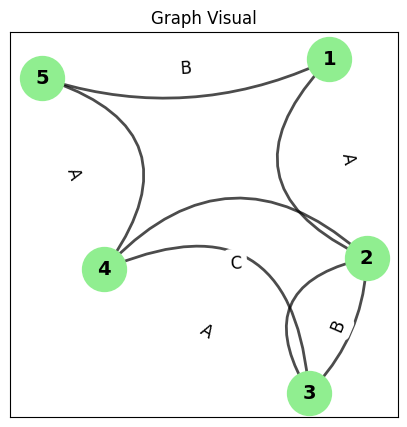

In [33]:
plot_multigraph(
    G_hamp, 
    type_curvature={"A": .7, "B": -0.2, "C": 0.5},
    figsize=(5,5),
    node_color="lightgreen",
    node_size=1000
)

The Hamiltonian path in the above example is the path defined by the vertices: $ 1 \rightarrow 2 \rightarrow 3 \rightarrow 4 \rightarrow 5$.

In part 1, we have discussed and proved one of the most important theorem in graph theory, the **Euler's theorem**. Such theorem can be stated as well for multigraphs:

**Theorem (Euler, 1736)**: Let $G=(V, E, \varphi)$ be a multigraph. Then:
$$
\sum_{v \in V(G)} \deg(v) = 2\cdot |E(G)|
$$
*Proof.* For each edge $e$, let us denote $\alpha(e)$ and $\beta(e)$ its endpoints. If $e$ is a loop, then $\alpha(e)=\beta(e)$. By definition of degree for multigraphs we have
$$
\deg(v) = \sum_{e \in E | v = \alpha(e)} 1 + \sum_{e \in E | v = \beta(e)}1
$$
notice that for a loop, the edge is counted twice, because $v$ is both $\alpha(e)$ and $\beta(e)$. Summing over all v:
$$
\begin{align}
\deg(v) &= \sum_{v\in V} \sum_{e \in E | v = \alpha(e)} 1 + \sum_{v\in V}\sum_{e \in E | v = \beta(e)} 1 \\
&= |E|+|E| = 2 |E|
\end{align}
$$
Indeed, if for each $v$ we sum the number of edges, we simply get the total number of edges. Therefore the theorem is proved. 

The definition of **graph isomorphism** is instead different for multigraphs, and a single bijective map between vertex of two graphs is not sufficient to define whether they are isomorphic or not. 

**Definition**: Let $G=(V, E, \varphi)$ and $H=(W, F, \psi)$ be two multigraphs. A **graph isomorphism** between $G$ and $H$ is a pair of bijective relations $(\phi_1, \phi_2)$:
$$
\begin{gather}
\phi_1: V \rightarrow W \\
\phi_2: E \rightarrow F
\end{gather}
$$
such that if $e \in E$, with endpoints $(v_1, v_2)$, then the endpoints of $\phi_2(e)$, say $w_1, w_2$, are the images under $\phi_1$ of the endpoints of $e$, i.e. $\phi_1(v_1) = w_1$.

### An applications of Multigraph in Social Network analysis

As you may have understood, multigraphs can be used in many real-life scenarios where relationships between entities are not straightforward and can be of multiple type. A common example is that of **social networks**, where edges can be used to represent "interactions" between persons and thus a multigraph can capture the variety of interactions that social network enables. Let us make a practical example, considering the following multigraph:

In [34]:
G_sn = nx.MultiGraph()

In [35]:
person_nodes = ["Alice", "Bob", "Hilbert", "Laplace", "Marie"]
interaction_edges = [("Alice", "Bob", 5, "DM"), 
                     ("Alice", "Bob", 2, "Comment"),
                     ("Bob", "Hilbert", 3, "DM"),
                     ("Hilbert", "Marie", 6, "Comment"),
                     ("Laplace", "Marie", 4, "Comment")
                    ]

In [36]:
G_sn.add_nodes_from(person_nodes)
G_sn.add_edges_from((u, v, weight, {"type": label, "weight": weight}) for u, v, weight, label in interaction_edges)

[5, 2, 3, 6, 4]

We have a multigraph representing a social network where people can interact in two ways: via "DM", i.e. *direct messages*, or with "Comment", i.e. *leaving* comment on friend's post. The multigraph is also "weighted" in the sense that we have assigned a number to each edge, indicating the number of interactions. Let's visualize the multigraph (we are using a drawing function provided by the `NetworkX` docs: look at the following link [Plotting Multigraph](https://networkx.org/documentation/stable/auto_examples/drawing/plot_multigraphs.html))

In [37]:
def draw_labeled_multigraph(G, attr_name, weight_name, ax=None):
    """
    Length of connectionstyle must be at least that of a maximum number of edges
    between pair of nodes. This number is maximum one-sided connections
    for directed graph and maximum total connections for undirected graph.
    """
    # Works with arc3 and angle3 connectionstyles
    connectionstyle = [f"arc3,rad={r}" for r in itertools.accumulate([0.15] * 4)]
    # connectionstyle = [f"angle3,angleA={r}" for r in it.accumulate([30] * 4)]

    pos = nx.shell_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color="lightblue", ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=20, ax=ax)
    nx.draw_networkx_edges(
        G, pos, edge_color="grey", connectionstyle=connectionstyle, ax=ax
    )

    labels = {
        tuple(edge): f"{attrs[attr_name]}|{weight_name}={attrs[weight_name]}"
        for *edge, attrs in G.edges(keys=True, data=True)
    }
    nx.draw_networkx_edge_labels(
        G,
        pos,
        labels,
        connectionstyle=connectionstyle,
        label_pos=0.5,
        font_color="blue",
        bbox={"alpha": 0},
        ax=ax,
    )

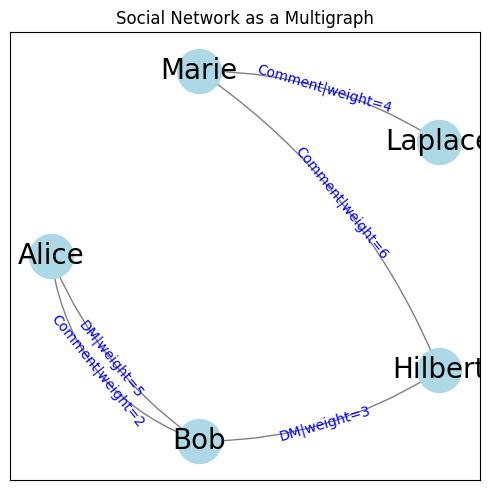

In [38]:
fig, ax = plt.subplots(figsize=(5, 5))
draw_labeled_multigraph(G_sn, "type", "weight", ax)
ax.set_title("Social Network as a Multigraph")
fig.tight_layout()
plt.show()

Of course, treating social network theory is beyond the scope of this notebook. Here, we are just giving an example of the application of multigraphs and show their capabilities to model such kind of problems. For instance, some simple analysis we could perform on such a graph may be the following:
- *finding the strongest communication channels*;
- *identifying persons mostly interacting with each other*

In [39]:
# Identifying persons with the highest interactions
sum_person_nteractions = {}
for person in G_sn.nodes():
    sum_person_nteractions[person] = sum(data["weight"] for i, v, data in G_sn.edges(data=True) if person in (i, v))

In [40]:
sum_person_nteractions

{'Alice': 7, 'Bob': 10, 'Hilbert': 9, 'Laplace': 4, 'Marie': 10}

In the above example, Bob has the highest interaction score (considered as the sum of interaction weights). As for the most used communication channels:

In [41]:
sum_interactions = {"DM": 0, "Comment": 0}
for u, v, data in G_sn.edges(data=True):
    type = data["type"]
    sum_interactions[type] += data["weight"]

In [42]:
sum_interactions

{'DM': 8, 'Comment': 12}

The "Comment" communication channel has insted the highest summed weights. 

Since we are talking about social network theory, let us now prove an interesting result in graph theory which leads to a curious features of social networks. Let $G=(V, E, \varphi)$ a multigraph with no loop and let $e \in E$ an edge of $G$. Let us assume that $v$ is an endpoint of $e$ and we denote as $e/v$ the endpoint of $e$ distinct from $v$. For each $v$ we define the following rational number $q_v$:
$$
q_v = \sum_{e \in E, v \in \varphi(E)} \frac{\deg(e/v)}{\deg(v)}
$$
Thus, $q_v$ is the *average degree of the neighbors of $v$*, weighted by the number of edges that join $v$ to its neighbors. We can prove that

<div style="text-align: center; border: 2px solid black; background-color: #D3D3D3; padding: 10px; display: inline-block; margin: auto;">
$$
\sum_{v\in V} q_v \geq \sum_{v \in V} \deg(v)
$$
</div>

In other words, *your average friend in a social network has, on average, more friends than you do!*. From the Euler's theorem, the above result can be restated as:
$$
\sum_{v\in V} q_v \geq 2|E|
$$
Summing over $v$ the expression of $q_v$ we get:
$$
\sum_v \sum_{e \in E, v \in \varphi(E)} \frac{\deg(e/v)}{\deg(v)} =  |E| \left( \frac{\deg(e/v)}{\deg(v)} + \frac{\deg(v)}{\deg(e/v} \right)
$$
Indeed, when summing over all nodes, for each edge, each endpoint will be once the first node and then the neighbor, thus the double sum is equivalent to multiply the expression in parenthesis by the number of edges in the graph. Now, consisder the following expression:
$$
(x-y)^2 \geq 0
$$
which is positive for any real positive number $x, y > 0 $. Therefore, 
$$
(x-y)^2 = x^2+y^2 - 2xy \geq 0 \Longrightarrow x^2+y^2 \geq 2xy
$$
Dividing by $xy$ both side (since $xy>0$):
$$
\frac{x^2}{xy}+\frac{y^2}{xy} = \frac{x}{y} + \frac{y}{x} \geq 2
$$
In the equation for $q_v$ we can recognize the expression given by the above inequality, therefore we by substitution:
$$
\sum_{v\in V} q_v = |E| \left( \frac{\deg(e/v)}{\deg(v)} + \frac{\deg(v)}{\deg(e/v} \right) \geq |E|\cdot 2 
$$
and thus the result is proved.

## Coloring Theory

In graph theory, **coloring** means *assigning labels - in general positive integers - to each vertex of a graph*. Such positive integers are 
called **colors**. Rougly speaking, we could say that coloring a graph is a way to "partition" its nodes into different groups, where each group is defined by a given color. Graph coloring theory has numerous applications in many fields. Some examples include:

- *scheduling problems*: coloring theory is often used to schedule jobs avoiding possible conflicts, and therefore to assign efficiently jobs to proper time slots. In this scenario, different jobs are nodes of a graph, edges between two jobs denote jobs sharing some resources. The objective is to color each node so that no pair of jobs share the same color (color are the available time slots). An example of this kind of problems is that of assigning aircraft to flights;
- *map coloring*: another possible application is that of "map coloring", i.e. the assignment of colors to regions in a map, ensuring that no adjacent regions share the same color;
- *networks*: graph coloring is ofted used in network communications, e.g. for assigning frequencies to devices such that there no adjacent devices using the same frequency.

Let us now give a rigorous mathematical definition of coloring:

**Definition**: Let $G=(V, E, \varphi)$ a multigraph and $k \in \mathcal{N}$. Then:
- A **$k$-coloring** of $G$ is a map $f : V \rightarrow \{ 1, 2, ..., k\}$. The integer numbers $1, 2, ..., k$ are called **colors** and given $v \in V$, $f(v)$ is corresponding color of $v$;
- A $k$-coloring of $G$ is said to be **proper** if no adjacent nodes of $G$ share the same color, i.e. $\nexists e \in E | f(u) = f(v), uv = e$.

For example, let us consider the Petersen graph (below we represent it in its classic layout):

In [48]:
# Build the Petersen graph
g_petersen = nx.petersen_graph()

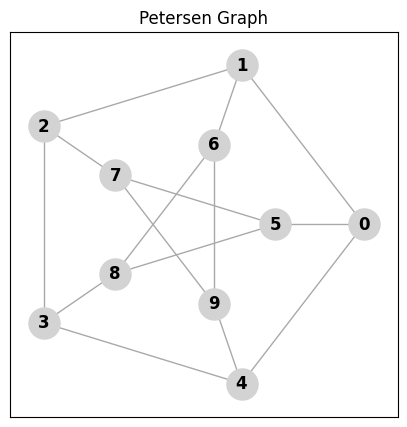

In [65]:
# Define fixed positions for a "nice" layout
positions = {}

# Outer pentagon nodes
for i in range(5):
    angle = 2 * np.pi * i / 5
    positions[i] = (np.cos(angle), np.sin(angle))

# Inner pentagram nodes
for i in range(5, 10):
    angle = 2 * np.pi * (i - 5) / 5 
    positions[i] = (0.5 * np.cos(angle), 0.5 * np.sin(angle))

# Draw the graph
plt.figure(figsize=(5, 5))
nx.draw_networkx(
    g_petersen, pos=positions, with_labels=True,
    node_size=500, node_color="lightgrey", font_size=12,
    font_weight='bold', edge_color='darkgrey'
)
plt.title("Petersen Graph")
plt.show()

This graph has a **3-proper coloring**, given by the following map:
$$
f: \{0, 1, 2, 3, 4, 5, 6, 7, 8, 9\} \rightarrow \{1, 2, 1, 2, 3, 2, 1, 3, 3, 1\}
$$

Indeed, using the following color map: 1 -> "blue", 2 -> "red", 3 -> "green":

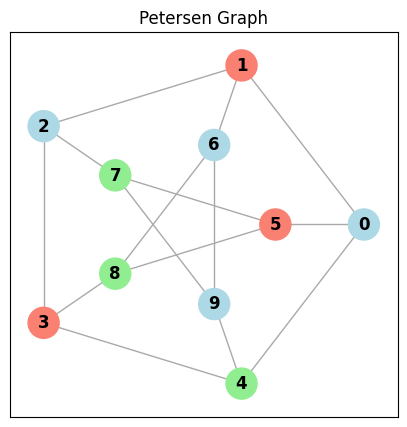

In [66]:
# Draw the graph -> we use light colors for a better visualization
color_map = { 1: "lightblue", 2: "salmon", 3: "lightgreen"}
three_coloring = [1, 2, 1, 2, 3, 2, 1, 3, 3, 1]
node_colors = [color_map[i] for i in three_coloring]


plt.figure(figsize=(5, 5))
nx.draw_networkx(
    g_petersen, pos=positions, with_labels=True,
    node_size=500, node_color=node_colors, font_size=12,
    font_weight='bold', edge_color='darkgrey'
)
plt.title("Petersen Graph")
plt.show()

As we can see, with the above defined coloring map, there are no adjacent nodes sharing the same color. In addition, we were able to properly color the graph with just three colors. Let us make another interesting example. Given $P_n$ and $P_m$ the $n$-th and $m$-th path graph respectively, we consider the Cartesian product $P_n \times P_m$, known as the **$(n, m)$-grid graph**. Such graph has 2-proper coloring map given by:
$$
(i, j) \rightarrow \begin{cases}
1 \ \text{if} \ i+j = 2n \\
2 \ \text{if} \ i+j = 2n+1 
\end{cases}
$$
with $n \in \mathbb{N}$. For instance, let us consider the following $(2, 3)$-grid graph:

In [74]:
gg_dims = (2, 3)
gg = nx.grid_graph(dim=gg_dims)

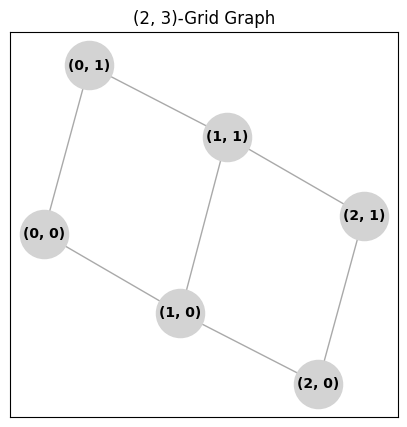

In [75]:
fig, ax = plt.subplots(figsize=(5, 5))

nx.draw_networkx(gg, with_labels=True, node_size=1200, node_color="lightgrey", font_size=10,
    font_weight='bold', edge_color='darkgrey'
)
plt.title(f"{str(gg_dims)}-Grid Graph")
plt.show()

Let us apply the color map defined above:

In [86]:
node_colors = []
for v in gg.nodes:
    # check if i+j is even
    if (v[0] + v[1]) % 2 == 0:
        node_colors.append("lightblue")
    # if odd, append another color
    else:
        node_colors.append("salmon")

In [87]:
node_colors

['lightblue', 'salmon', 'salmon', 'lightblue', 'lightblue', 'salmon']

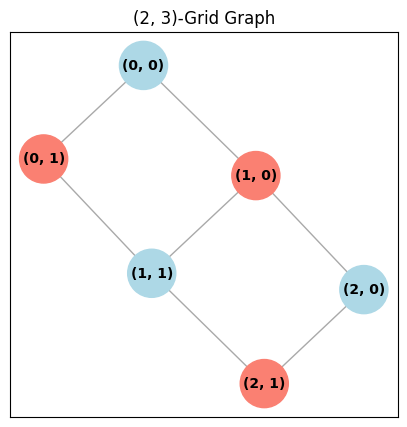

In [88]:
fig, ax = plt.subplots(figsize=(5, 5))

nx.draw_networkx(gg, with_labels=True, node_size=1200, node_color=node_colors, font_size=10,
    font_weight='bold', edge_color='darkgrey'
)
plt.title(f"{str(gg_dims)}-Grid Graph")
plt.show()

Such coloring is also known as the **chessboard coloring**, since it is the same coloring scheme used in chessboards. 

**Definition**: Let $G=(V, E, \varphi)$ a multigraph. The smallest number of colors, $\chi(G)$, needed to proper coloring a graph is called the **chromatic number** of $G$. 

With the above examples, we were able to easily find a proper coloring and map - and the corresponding chromatic number - by  a direct inspection of nodes and graph connectivity. For instance, it's clear that the chromatic number of the $(n, m)$-grid graph is 2. However, in general terms, finding a proper k-coloring is a hard computational problem, unless $k \leq 2$. However, there exist at least some sufficient criteria to establish whether a graph can have or not a proper coloring. One of the most important is the so-callled **Brooks Theorem**, for which there exist two versions discussed in the following section.

###  The Brooks Theorems

**Theorem( Little Brooks Theorem)**: Let $G=(V, E, \varphi)$ a loopless *complete* multigraph with at least one vertex and let $\alpha$ be the maximum degree of $G$. Then, the chromatic number of $G$ is $(\alpha + 1)$. 

We remind that a *complete graph*, generally denoted as $K_n$ is a graph in which each pair of distinct vertices is connected by an edge. Therefore, by definition a complete graph $K_n$ with $n$ nodes has maximum degree of $n-1$. 

Let's test empirically this theorem applying a Depth-First Search algorithm approach. Basically, we can do the following:
1. We generate a list of possibile $\alpha+1$ colors where $\alpha$ is the max degree of the graph;
2. We start traversing the graph with DFS. We start from a given node, say the first, and assign a color (at first we can simply assign an integer number starting from 0, since Python use zero-indexing). The color must be different from each color assigned to the node neighbors, therefore we need to keep track of forbidden colors;
3. We iterate over each node, thus exploring the whole graph

In [186]:
# A function to generate N random colors:
def generate_random_colors(N):
    '''
    Function to generate random HEX colors
    '''
    return [mcolors.to_hex((random.random(), random.random(), random.random())) for i in range(N)]

In [189]:
# Example graph
lbt_graph = nx.complete_graph(5)

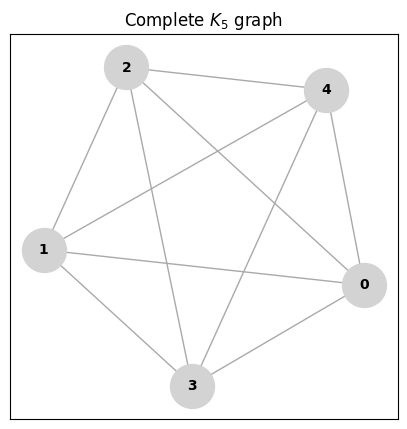

In [196]:
fig, ax = plt.subplots(figsize=(5, 5))

nx.draw_networkx(lbt_graph, with_labels=True, node_size=1000, node_color="lightgrey", font_size=10,
    font_weight='bold', edge_color='darkgrey'
)
plt.title(fr"Complete $K_5$ graph")
plt.show()

In [198]:
# Getting the max degree
max_deg = max([lbt_graph.degree(v) for v in lbt_graph.nodes()])
print(f"The maximum degree of the given graph is: {max_deg}")

The maximum degree of the given graph is: 4


In [200]:
# Generate a number of colors equal to max_deg+1
available_colors = generate_random_colors(max_deg+1)
print(f"The number of available colors is {max_deg} + 1 =  {len(available_colors)}")

The number of available colors is 4 + 1 =  5


In [201]:
def greedy_coloring(G: nx.MultiGraph, all_colors: list) -> dict:
    '''
    Function that use a DFS approach to proper coloring a given graph

    Args:
        G (nx.MultiGraph) : a NetworkX MultiGraph
        all_colors (list(str)): a list of colors

    Returns:
        (dict) : A dictionary mapping each node to a given color
    '''

    # Color assignment is the mapping node -> color (integer number), we initialize them to -1 
    color_assignment = {node: -1 for node in G.nodes() }
    
    # We create two empty set: one to store visited nodes and the other to store forbidden colors
    visited_nodes = set()
    forbidden_colors = set()

    # We define an inner recursive DFS function
    def DFS(v):
        # We add the given nodd to visited node
        visited_nodes.add(v)

        # Cycle over v neighbors and update forbidden colors
        for neighbor in G.neighbors(v):
            if color_assignment[neighbor] != -1:
                forbidden_colors.add(color_assignment[neighbor])
    

        # Now we assign the first available color
        for color in range(len(G.nodes())):
            if color not in forbidden_colors:
                color_assignment[v] = color
                break

        # Finally we iterate over v neighbors and for not visited neighbor we call recursively DFS()
        for neighbor in G.neighbors(v):
            if neighbor not in visited_nodes:
                DFS(neighbor)


    # We cycle over each node of G and call DFS() if v is not already visited
    for v in G.nodes():
        if v not in visited_nodes:
            DFS(v)


    # Finally, we re-map colors (integer number) to true "colors" and return the coloring map
    map_coloring = {i: available_colors[i] for i in range(len(available_colors))}
        
    return {node: map_coloring[i] for node, i in color_assignment.items()}

In [202]:
lbt_coloring = greedy_coloring(lbt_graph, available_colors)

Let's check now how many colors we have used from the list of size $\alpha + 1$, with $\alpha = (n-1)$ for the given complete graph:

In [203]:
# Check how many distinct colors were used
num_used_colors = len(set(lbt_coloring.values()))
print(f"Number of colors used: {num_used_colors}")
print(f"Initial color list size: {len(available_colors)}")

Number of colors used: 5
Initial color list size: 5


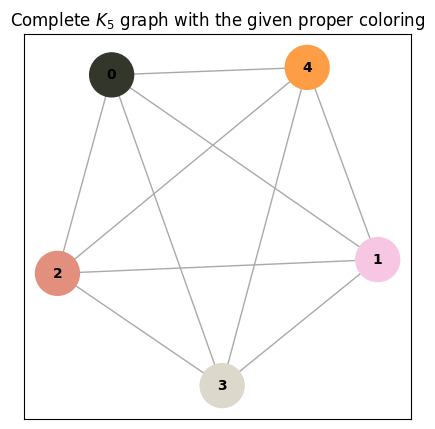

In [204]:
fig, ax = plt.subplots(figsize=(5, 5))

nx.draw_networkx(lbt_graph, with_labels=True, node_size=1000, node_color=lbt_coloring.values(), font_size=10,
    font_weight='bold', edge_color='darkgrey'
)
plt.title(fr"Complete $K_5$ graph with the given proper coloring")
plt.show()

At first glance, this may be a rather obvious result: in a complete graph, each node is connected to the other $n-1$ nodes, therefore the max degree is $n-1$. Since in a proper coloring, we cannot have the same color for two adjacent nodes, then it follows that each node $v$ must have $(n-1)$ different neighboring colors. Adding the distinct color we must use for node $v$, it follows that the smallest number of colors needed is $(n-1)+1 \equiv \max_v (\deg(v))+1$. Actually, we can extend the above theorem and say that: if $G$ is a loopless multigraph (not necessarily complete) and $\alpha$ is the maximum degree, then it has $G$ a $\alpha+1$ proper coloring (we are not saying that its chromatic number is $\alpha+1$!). The method coded above is actually an empirical prove of this statement - and it basically follows the skecthed proof of the Little Brooks Theorem given by D. Grindberg, see *References*. Indeed, at each step we are assignig color to each node, picking from a list of colors different from colors already assigned to its neighbors. Since $v_i$ has at most $\max_v(\deg(v))= \alpha$ neighbors, we have at most $\alpha$ colors to avoid. However, we have started from a list of $\alpha+1$ colors in total, so we always have one color left and we never run out of colors! Such $\alpha+1$ coloring is generally known as **greedy coloring** - since it basically applies a *greedy* decision at each step.

Let's make an example with a non-complete graph:

In [213]:
lbt_graph2 = nx.MultiGraph()
lbt_graph2.add_nodes_from([1, 2, 3, 4, 5, 6])
lbt_graph2.add_edges_from([(1, 2), (2, 3), (3, 4), (3, 5), (3, 1), (1, 6), (3, 6)])

[0, 0, 0, 0, 0, 0, 0]

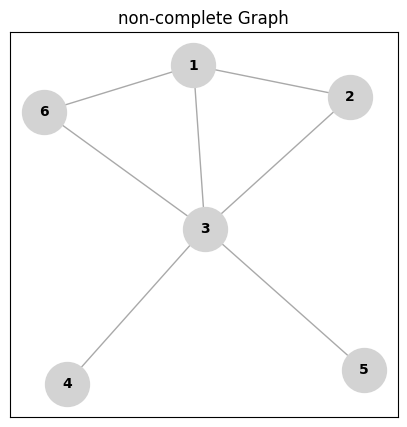

In [214]:
fig, ax = plt.subplots(figsize=(5, 5))

nx.draw_networkx(lbt_graph2, with_labels=True, node_size=1000, node_color="lightgrey", font_size=10,
    font_weight='bold', edge_color='darkgrey'
)
plt.title(f"non-complete Graph")
plt.show()

In [215]:
# Getting the max degree
max_deg = max([lbt_graph2.degree(v) for v in lbt_graph2.nodes()])
print(f"The maximum degree of the given graph is: {max_deg}")

The maximum degree of the given graph is: 5


In [216]:
# Generate a number of colors equal to max_deg+1
available_colors2 = generate_random_colors(max_deg+1)
print(f"The number of available colors is {max_deg} + 1 =  {len(available_colors2)}")

The number of available colors is 5 + 1 =  6


In [217]:
lbt2_coloring = greedy_coloring(lbt_graph2, available_colors2)

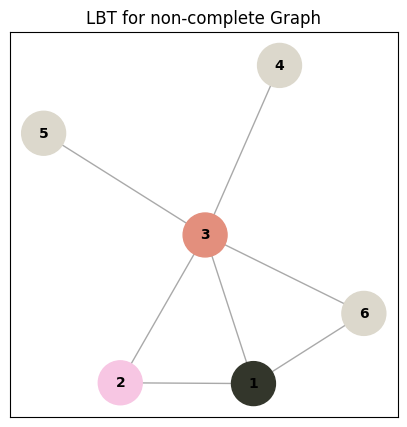

In [218]:
fig, ax = plt.subplots(figsize=(5, 5))

nx.draw_networkx(lbt_graph2, with_labels=True, node_size=1000, node_color=lbt2_coloring.values(), font_size=10,
    font_weight='bold', edge_color='darkgrey'
)
plt.title(f"LBT for non-complete Graph")
plt.show()

In [219]:
# Check how many distinct colors were used
num_used_colors = len(set(lbt2_coloring.values()))
print(f"Number of colors used: {num_used_colors}")
print(f"Initial color list size: {len(available_colors2)}")

Number of colors used: 4
Initial color list size: 6


Notice that in the above example we have found $4$-proper coloring of $G$. Of course, if $G$ has a $k$-proper coloring than it also has a $j$-proper coloring with $j > k$. Since the maximum degree of nodes in $G$ is 5, then $G$ will have a 6-proper coloring, given by assigning a distinct color to each node. We can formulate a strongest version of the Little Brooks Theorem, which is way more harder to prove and thus we omit here:

**Theorem (Brooks)**: Let $G=(V, E, \varphi)$ be a connected multigraph of maximum degree $\alpha$. Then the **chromatic number** $\chi(G) \leq \alpha+1$, where equality holds *if and only* if $G$ is a complete graph or an odd cycle.

`networkx` provide a method for coloring a graph using greedy graph coloring. The method is called `nx.coloring.greedy_color`. Its main parameter is the so-called `strategy`. Such parameter allows specifying a coloring strategy to use. For instance:

In [246]:
G_c3 = nx.cycle_graph(3)

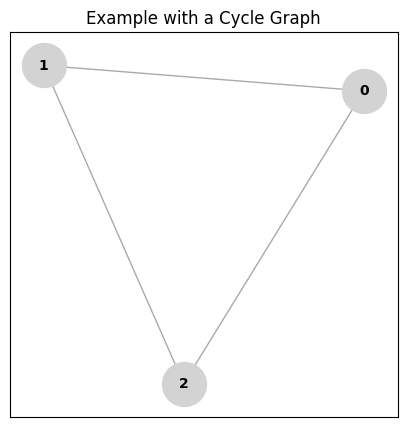

In [247]:
fig, ax = plt.subplots(figsize=(5, 5))

nx.draw_networkx(G_c3, with_labels=True, node_size=1000, node_color="lightgrey", font_size=10,
    font_weight='bold', edge_color='darkgrey'
)
plt.title(f"Example with a Cycle Graph")
plt.show()

In [248]:
c3_gcoloring_rs = nx.coloring.greedy_color(G_c3, strategy="random_sequential")
c3_gcoloring_sl = nx.coloring.greedy_color(G_c3, strategy="smallest_last")

In [249]:
c3_gcoloring_rs, c3_gcoloring_sl

({0: 0, 1: 1, 2: 2}, {2: 0, 1: 1, 0: 2})

For example, with the `random_sequential` strategy, the order in which nodes are returned (and therefore the assigned colors) is random (the color assignment itself is of course not random but sequential, as we can see from the above integer numbers). Instead, with the `smallest_last` strategy, nodes are returned from the largest to the smallest one.

### The chromatic polynomial

We now introduce another central topic in graph coloring theory: the **chromatic polynomial of a graph**. While there is extensive literature on this subject, we will cover only the basics here. Interested readers can find references at the end of this notebook.

Let's first give an not "rigorous" definition. A chromatic polynomial $\chi(G, k)$ is a **<span style="color: red">function of $G$ and a variable $k$, defining the number of $x$-proper coloring of $G$ with $x\leq k$</span>**. In other words, it is the number of ways of proper coloring a graph $G$ with $k$ or fewer colors. Let's make an example. We consider the cycle graph $C_3$ sketched above. It is straighforward to see that this graph neither has a proper 1-coloring nor a 2-coloring. Instead, it has a trivial 3-proper coloring, obtained by assigning a distinct color to each node. How many coloring we can realize with three colors? By permuting the three distinct colors among the three vertices, we will get $3!= 6$ distinct colorings. Therefore, we could write the following function for $C_3$:
$$
\chi(C_3, k) = k(k-1)(k-2)
$$
This function is polynomial in the variable $k$, thus justying the name of **chromatic polynomial**. We shall prove in the following that $\chi$ is indeed always a polynomial in $k$. 

**Theorem (Deletion-Contraction)**: Let $G=(V, E, \varphi)$ be a multigraph. Let $G-e$ be the graph with the edge $e$ removed (a **deletion**) and $G/e$ the graph with edge $e$ removed and the nodes $uv=e$ contracted into a single vertex (a **contraction**). Then,
$$
\chi(G, k) = \chi(G-e, k) - \chi(G/e, k)
$$

We give here just an empirical evidence, using again the example of the cycle graph $C_3$. First of all, let's draw the graphs $C_3-e$ and $C_3/e$:

In [257]:
G_c3.nodes()

NodeView((0, 1, 2))

In [258]:
G_c3_e_deletion = nx.cycle_graph(3)
G_c3_e_deletion.remove_edge(0, 1)

In [259]:
# Contracting edge, avoiding self-loops formation
G_c3_e_contraction = nx.contracted_edge(G_c3, (0, 1), self_loops=False)

Text(0.5, 1.0, '$C_3/e$ graph')

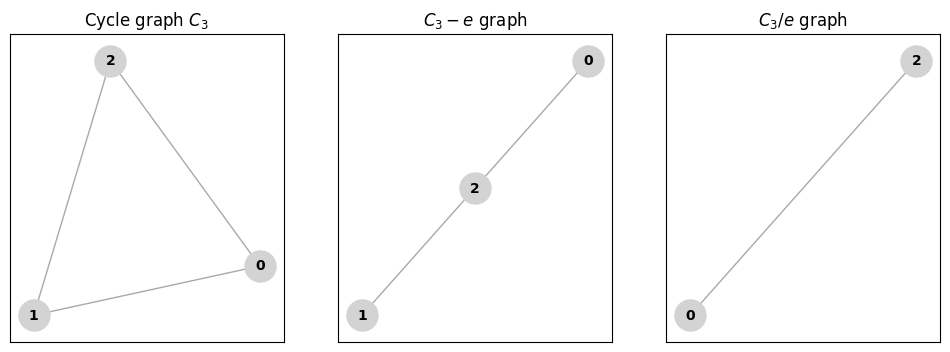

In [260]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

drawing_graphs = [G_c3, G_c3_e_deletion, G_c3_e_contraction]

for i, graph in enumerate(drawing_graphs):
    nx.draw_networkx(graph, 
                     node_size=500, node_color="lightgrey", 
                     font_size=10, font_weight='bold', 
                     edge_color='darkgrey', ax=ax[i]
    )
ax[0].set_title(f"Cycle graph $C_3$")
ax[1].set_title(f"$C_3-e$ graph")
ax[2].set_title(f"$C_3/e$ graph")

Let's consider the $C_3-e$ graph. Finding its chromatic polynomial is quite simple as for the original cycle graph:

- For vertex $0$, we can pick a color from the $k$ color available in case of $k$-coloring;
- For vertex $2$, we can pick a color from the remaining $k-1$ colors;
- For vertex $1$, we have still $k-1$ color available, since we could use again the first color assigned to $0$

Hence, the chromatic polynomial will be:
$$
\chi(C_e-e, k) = k(k-1)^2
$$
Indeed, for $k=2$, we have just 2 possibile proper coloring:

Text(0.5, 1.0, '$C_3-e$ graph')

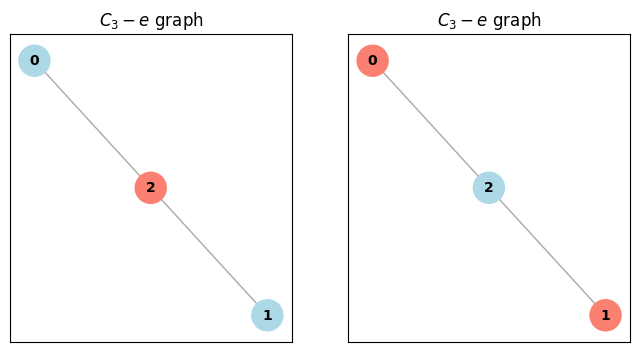

In [264]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

two_colorings_G_c3_e_contraction = [
    ["lightblue", "lightblue", "salmon"], 
    ["salmon", "salmon", "lightblue"]
]

for i, two_coloring in enumerate(two_colorings_G_c3_e_contraction):
    nx.draw_networkx(G_c3_e_deletion, 
                     node_size=500, node_color=two_coloring, 
                     font_size=10, font_weight='bold', 
                     edge_color='darkgrey', ax=ax[i]
    )
ax[0].set_title(f"$C_3-e$ graph")
ax[1].set_title(f"$C_3-e$ graph")

In case of 3 colors, we could realize $3(3-1)^2 = 12$ proper colorings. Indeed, for the first node we can choose among three possibile colors. For the second node, we can choose among 2 colors; for the remaining node we can choose again among 2 different colors, since this must just be different from the second one. Thus for each node, we have $2\times 2$ configuration, for a total of $3\times 4 = 12$ colorings. 

For $C_3/e$ graph, for the first node we have $k$ possibile choices; for the second node we have $k-1$ choices. Therefore, the chromatic polynomial will be:
$$
\chi(C_3/e, k) = k(k-1)
$$
Now, let us consider the expression of $\chi(C_3-e)$. We can rewrite it as follows:
$$
\begin{align}
\chi(C_3-e, k) &= k(k-1)^2 = k(k-1)(k-1) \\
&=k(k-1)k - k(k-1) =(k-2+2)(k-1)k-k(k-1)\\
&= (k-2)(k-1)k+2k(k-1)-k(k-1) = (k-2)k-1)k+k(k-1)
\end{align}
$$
Thus, 
$$
\chi(C_3-e, k) = \chi(C_3, k) + \chi(C_3/e, k)
$$
which rearranged gives the equation of the Contraction-Deletion theorem.

**Thereom**: The chromatic polynomial of the empty graph $G$ is $\chi(G, k) = k^n$ where $n$ is the number of nodes.

*Proof*. An empty graph is a graph with $n$ nodes and zero edges. Therefore, it consists of $n$ *connected components* of one node. For each color, we can pick a color among the $k$ available color indipendently, therefore:
$$
\chi(G, k) = \underbrace{k \cdot k \cdot k \cdot \cdots \cdot k}_{n \ \text{times}} = k^n
$$

<div style="border: 2px solid #ff8080; background-color: #ffe6e6; padding: 10px; border-radius: 5px; margin: 10px 0;">

**Theorem**
The chromatic polynomial of $G$, $\chi(G, k)$ is always a **polynomial function in $k$**
</div>

*Proof*. Let consider a graph with $n$ vertices and 0 edges. Then, we know that its chromatic polynomial is $k^n$. Now, by induction, let us assume that all graphs with fewer than $m$ edges has a chromatic polynomial which is a polynomial function of $k$. Let $G$ be a graph with $m$ edges. Then, by the Contraction-Deletion theorem we could write:
$$
\chi(G, k) = \chi(G-e, k) - \chi(G/e, k)
$$
$G-e$ has $m-1$ edges while $G/e$ has fewer than $m$ edges by definition, therefore their chromatic polynomials are polynomial functions in $k$. Since the chromatic polynomial of $G$ is obtained by subtracting the chromatic polynomial of $G-e$ and $G/e$, it follows that $\chi(G, k)$ is also a polynomial function in $k$. 

This theorem establishes a fundamental property of graphs: **<span style="color: red">no matter how complitcated is the topology and geometry of a graph, its chromatic polynomial will always be a polynomial function in one variable, $k$</span>**.

In the example given above, we were able to write an explicit expression for the chromatic polynomial through a simple inspection of the graph structure. However, calculating the chromatic polynomial is not usually this straightforward. Nevertheless, it is possible to derive explicit formulas for the chromatic polynomial, mainly thanks to the works of G. Birkhoff and H. Whitney in the early 20th century. In the following, we will present two of the most well-known formulas for expressing the chromatic polynomial, without providing formal proofs (see References). 

Before, stating these formulas, we need the following definition:

**Definition**: A **spanning subgraph** of a multigraph $G=(V, E, \varphi)$ is a multigraph of the form $H=(V, F, \varphi |_F)$, where $F$ is a subset of $E$. 

In other words, a spanning subgraph of $G$ is a multigraph obtained by removing some edges from $G$, without modifying the vertices. 

<div style="border: 2px solid #ff8080; background-color: #ffe6e6; padding: 10px; border-radius: 5px; margin: 10px 0;">
    
**Theorem (explicit formula)**
Let $G=(V, E, \varphi)$ be an undirected multigraph. Its chromatic polynomail $\chi(G, k)$ is given by:
$$
\chi(G, k) = \sum_{S\subseteq E}(-1)^{|S|}k^{c(G(S))}
$$

where $c(G)$ is the number of connected components of $G$, $G(S)$ is the spanning subgraph of $G$ with edge set $S$. 
</div>

In the above formula, the sum runs over "all possible subsets of $E$". Let us make an example, considering the following graph:

In [314]:
G_ef = nx.Graph()
G_ef.add_nodes_from([1, 2, 3, 4])
G_ef.add_edges_from([(1, 2), (1, 3), (1, 4)])

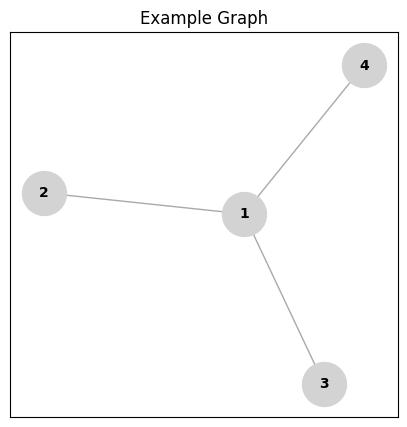

In [266]:
fig, ax = plt.subplots(figsize=(5, 5))

nx.draw_networkx(G_ef, with_labels=True, node_size=1000, node_color="lightgrey", font_size=10,
    font_weight='bold', edge_color='darkgrey'
)
plt.title(f"Example Graph")
plt.show()

To apply the explicit formula, we need to list all possibile subsets of $E$. Look at the image below:
![Spanning-Subgraphs](../images/spanning-subgraphs-ex.png)

We have colored in red all possible subsets of $E$. The corresponding spanning subgraphs are obtained by removing the edge not colored in red. Therefore, for the first graph, removing the black edges leads to a graph with 4 disconnected vertices, i.e. 4 connected components. The number of edges is 0, therefore the first term of the chromatic polynomial will be $(-1)^0 k^4 = k^4$. For the second graph, removing black edges leads to a graph with three connected components. In this case, the number of edges in the spanning subgraph is 1, hence the corresponding term of the chromatic polynomial will be $(-1)^1k^3 = -k^3$. Then, applying these arguments to the remaining terms, we get:
$$
\begin{align}
\chi(G, k) &= k^4 + (-1)^1k^3 + (-1)^1k^3 + (-1)^1k^3 + \\
&+ (-1)^2k^2 + (-1)^2k^2 + (-1)^2k^2 + (-1)^3k^1 \\
&= k^4 - 3k^3 -3k^2 -k
\end{align}
$$

`networkx` shines again and allows easily computing the chromatic polynomial of a graph with a simple function call, `nx.chromatic_polynomial`:

In [268]:
# Printing the chromatic polynomial of a graph
nx.chromatic_polynomial(G_ef)

x**4 - 3*x**3 + 3*x**2 - x

For the sake of completeness, we report also another formulation of the chromatic polynomial formula, which arises from the previously states *Deletion-Contraction Theorem*.

<div style="border: 2px solid #ff8080; background-color: #ffe6e6; padding: 10px; border-radius: 5px; margin: 10px 0;">
    
**Fundamental Reduction Theorem**
Let $G=(V, E, \varphi)$ be an undirected multigraph. Its chromatic polynomail $\chi(G, k)$ is given by:
$$
\chi(G, k) = \begin{cases}
k^{n(G)} \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \text{if} \ e(G)=0 \\
\chi(G-e, k) - \chi(G/e, k) \ \ \text{otherwise}
\end{cases}
$$

where $n(G)$ is the number of nodes of $G$, $e(G)$ is the number of edges of $G$ and $G-e, G/e$ are the $e$-deleted and $e$-contracted graph respectively. Such expression is also known as the **chromatic recurrence**.
</div>

The above formula can be easily implemented in Python with a recursive approach:

In [329]:
def chromatic_recurrence(G):
    '''
    Function returning the chromatic polynomial of G as a string 
    '''
    # If G has no edges, returning k^n
    if len(G.edges) == 0:
        return f"k**{len(G.nodes())}"

    # if G has some edges:
    if len(G.edges) > 0:

        # Creating a copy of G for deletion
        G_deleted = nx.Graph(G)

        # Cycle over G edges:
        for e in G.edges():
            
            # Deleting edge to generate G-e
            G_deleted.remove_edge(e[0], e[1])
            # Create G/e by contraction of e
            G_contracted = nx.contracted_edge(G, e, self_loops=False)

            # Returning the recurrence formula
            return f"({chromatic_recurrence(G_deleted)}) - ({chromatic_recurrence(G_contracted)})"

In [335]:
G_ef_chromatic_poly_str = chromatic_recurrence(G_ef)

In [336]:
print(f"The chromatic polynomial of the given graph is: {G_ef_chromatic_poly_str}")

The chromatic polynomial of the given graph is: (((k**4) - (k**3)) - ((k**3) - (k**2))) - (((k**3) - (k**2)) - ((k**2) - (k**1)))


The provided function returns the chromatic polynomial as a string - hence we have the single powers of $k$. We can use the Python library `sympy` to *evaluate* the function to a given $k$. For instance, to compute the $\chi(G, 3)$, i.e. the number of proper coloring for graph $G$ (the one of the example above) with 3 or less colors:

In [340]:
def evaluate_chromatic_polynomial(chromatic_polynomial_expression: str, symbol: str,  value: int) -> float:
    '''
    Function to evaluate the chromatic polynomial 

    Args:
        chromatic_polynomial_expression (str): The chromatic polynomial as a string, compatible with sympy syntax
        symbol (str): the symbol used in the expression
        value (int): the value to which evaluate the polyomial

    Returns:
        \chi(G, k)
    '''
    
    k = symbols(symbol)
    
    # Convert string to a sympy expression and substitute the given symbol
    expr = sympify(chromatic_polynomial_expression)
    
    return expr.evalf(subs={k: value})

In [341]:
evaluate_chromatic_polynomial(G_ef_chromatic_poly_str, "k", 3)

24.0000000000000

At first glance, the theory of chromatic polynomials may seem like a purely theoretical mathematical exercise without any practical application. However, this is not the case. Computing and evaluating chromatic polynomials can be applied to various problems that can be modeled using graph theory. One notable example is the problem of frequency assignment in wireless networks.

To keep it simple, imagine we have four cell towers. If two towers are too close, their signals can interfere with each other. Therefore, engineers need to assign different frequencies to adjacent towers to minimize interference. This problem can be modeled within graph theory: towers represent nodes, and edges between nodes indicate potential interference between towers. The goal is to assign different frequencies to adjacent towers while minimizing the number of frequencies used. Let's consider the following cycle graph where nodes represent towers:

In [351]:
graph_towers = nx.cycle_graph(4)

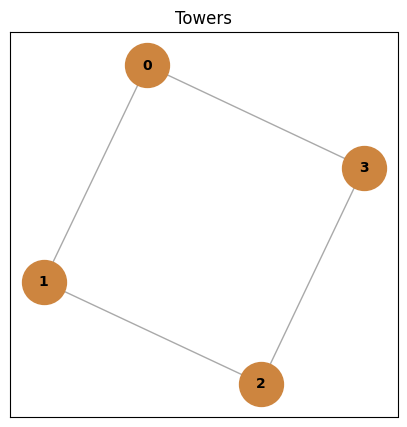

In [352]:
fig, ax = plt.subplots(figsize=(5, 5))

nx.draw_networkx(graph_towers, with_labels=True, node_size=1000, node_color="peru", font_size=10,
    font_weight='bold', edge_color='darkgrey'
)
plt.title(f"Towers")
plt.show()

Computing the chromatic polynomial, we find:

In [353]:
graph_towers_chromatic_poly_str = chromatic_recurrence(graph_towers)

graph_towers_chromatic_poly_str

Evaluting the polynomial at different $k$, we get:

In [358]:
for i in range(1, 4):
    chi_i = evaluate_chromatic_polynomial(graph_towers_chromatic_poly_str, "k", i)
    print(f"The number of proper coloring with k<={i} is: {chi_i}")

The number of proper coloring with k<=1 is: 0E-124
The number of proper coloring with k<=2 is: 2.00000000000000
The number of proper coloring with k<=3 is: 18.0000000000000


We see that, two frequencies are sufficient to assign different frequencies to each pair of adjacent towers and the number of proper coloring (i.e. frequency assignment) we can realize is 2, the number given by evaluating the chromatic polynomial.

There a lot of other interesting results in graph coloring theorem - such as the so-called **four-color theorem**, which basically states that *no more than four colors are required to color the regions of any map so that no two adjacent regions have the same color* ([Wikipedia](https://en.wikipedia.org/wiki/Four_color_theorem)) - but this notebook does not pretend to be exhaustive about this topic. The interested reader can find some references at the end of this notebook. 

We conclude this section about chromatic polynomials by showing the shape of the chromatic polynomials of the main class of graphs treated so far:

In [382]:
def path_graph_chi(n, k):
    return k*np.pow(k-1, n-1)
    
def complete_graph_chi(n, k):
    chi_nk = 1
    i = 0
    while i != n:
        chi_nk *= k-i
        i += 1
    return chi_nk
    
def cycle_graph_chi(n, k):
    return (k-1)**n + np.pow(-1, n)*(k-1)

def edgeless_graph_chi(n, k):
    return np.pow(k, n)

In [410]:
graph_data = {}
k_values = np.arange(-1, 3, 0.1)

graph_data["path"] = [path_graph_chi(3, k) for k in k_values]
graph_data["complete"] = [complete_graph_chi(3, k) for k in k_values]
graph_data["cycle"] = [cycle_graph_chi(3, k) for k in k_values]
graph_data["edgless"] = [edgeless_graph_chi(3, k) for k in k_values]

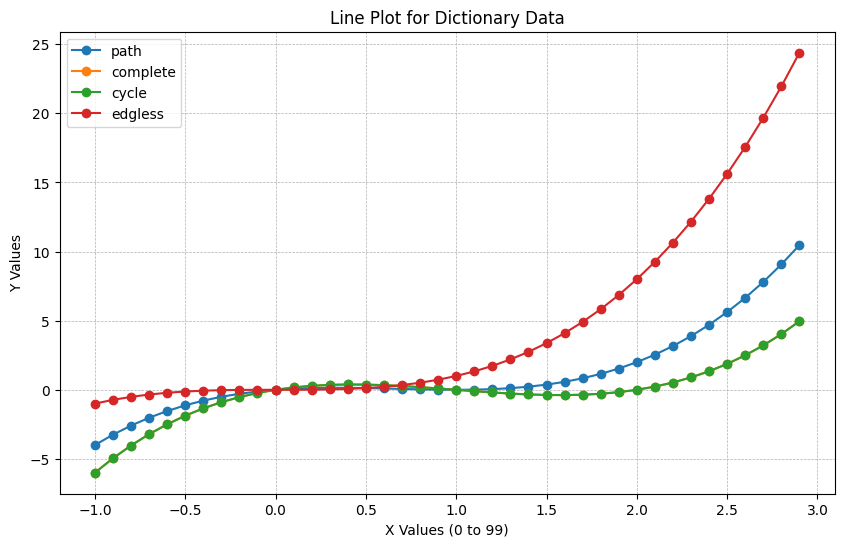

In [412]:
# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each series in the dictionary
for key, y_values in graph_data.items():
    ax.plot(k_values, y_values, label=key, marker="o")

# Add labels, title, and legend
ax.set_title('Line Plot for Dictionary Data')
ax.set_xlabel('X Values (0 to 99)')
ax.set_ylabel('Y Values')
ax.legend()

# Show grid for better readability
ax.grid(True, linestyle='--', linewidth=0.5)

## Introduction to Algebraic Graph Theory: the Adjacency Matrix

## References

- *An introduction to graph theory*, Darij Grinberg, arXiv:2308.04512v2 (2024)
- [*NetworkX Tutorial*](https://networkx.org/documentation/stable/tutorial.html)

In [101]:
random.choice([1, 2, 3])

2